In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.autograd as ag

from matplotlib import pyplot
from tqdm import trange
import pandas as pd
import cv2
import glob
import pickle


In [2]:
# categories = glob.glob('pokemon/PokemonTypesDeepLearning/Images/data/*')
# xtrain = []
# ltrain = []
# for cat in categories:
#     image_files = glob.glob(cat + "/*")
#     for image in image_files:
#         img = cv2.imread(image)
#         if img.shape == (32, 32, 3):
#             xtrain.append(img)
#             ltrain.append(cat.split("/")[-1])
        

In [3]:
# Loading from xtrain
with open('pokemon_xtrain.pickle', 'rb') as handle:
    xtrain = pickle.load(handle)

with open('pokemon_ltrain.pickle', 'rb') as handle:
    ltrain = pickle.load(handle)

In [4]:
# len(xtrain), len(ltrain), [xtrain[i].shape for i in range(len(ltrain))]

In [5]:
xtrain = np.array(xtrain)
ltrain = np.array(ltrain)

In [6]:
classes = list(set(ltrain))
print(classes)
all_inds = []
for clas in classes:
    inds = (np.where(ltrain == clas)[0])

    inds = np.random.choice(inds, 200)
    all_inds.extend(inds)

ltrain = ltrain[all_inds]
xtrain = xtrain[all_inds]

['Steel', 'Dark', 'Electric', 'Normal', 'Fire', 'Psychic', 'Fighting', 'Poison', 'Dragon', 'Water', 'Ghost', 'Ice', 'Rock', 'Fairy', 'Grass', 'Bug', 'Ground']


In [7]:
sci = np.arange(len(xtrain))
np.random.shuffle(sci)
sci

array([ 117, 1253, 2194, ..., 1761, 3058, 2649])

In [8]:
xtrain = xtrain[sci]
ltrain = ltrain[sci]

In [9]:
xtrain = xtrain.astype(np.float64) / xtrain.max()
# xtrain[0][0]

In [10]:

tmp = dict(zip(classes, range(len(classes))))
inds = map(lambda x:tmp[x], ltrain)
one_hot = np.zeros((len(ltrain), len(classes)))
one_hot[range(len(ltrain)), inds] = 1
one_hot.sum(axis=0)
ltrain = one_hot

In [11]:
xtrain = np.moveaxis(xtrain, [1, 2, 3], [2, 3, 1])
xtrain.shape

(3400, 3, 32, 32)

In [12]:
val_idx = np.random.uniform(size=(len(xtrain),)) < 0.2
xval = xtrain[val_idx]
lval = ltrain[val_idx]
neg = (1-val_idx).astype(bool)
xtrain = xtrain[neg]
ltrain = ltrain[neg]

In [13]:
ltrain.shape, lval.shape

((2685, 17), (715, 17))

In [14]:
# with open('pokemon_xtrain_split.pickle', 'wb') as handle:
#     pickle.dump(xtrain, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('pokemon_ltrain_split.pickle', 'wb') as handle:
#     pickle.dump(ltrain, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('pokemon_xval_split.pickle', 'wb') as handle:
#     pickle.dump(xval, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('pokemon_lval_split.pickle', 'wb') as handle:
#     pickle.dump(lval, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('pokemon_classes.pickle', 'wb') as handle:
#     pickle.dump(classes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:

with open('pokemon_xtrain_split.pickle', 'rb') as handle:
    xtrain = pickle.load(handle)

with open('pokemon_ltrain_split.pickle', 'rb') as handle:
    ltrain = pickle.load(handle)

with open('pokemon_xval_split.pickle', 'rb') as handle:
    xval = pickle.load(handle)

with open('pokemon_lval_split.pickle', 'rb') as handle:
    lval = pickle.load(handle)

with open('pokemon_classes.pickle', 'rb') as handle:
    classes = pickle.load(handle)

In [16]:
xtrain = torch.from_numpy(xtrain).double()
ltrain = torch.from_numpy(ltrain).long()
xval = torch.from_numpy(xval).double()
lval = torch.from_numpy(lval).long()

if torch.cuda.is_available():
    xtrain = xtrain.cuda()
    ltrain = ltrain.cuda()
    xval = xval.cuda()
    lval = lval.cuda()

xtrain_target = ag.Variable(xtrain, requires_grad=False)
xtrain = ag.Variable(xtrain, requires_grad=True)
ltrain = ag.Variable(ltrain, requires_grad=False)
xval = ag.Variable(xval, requires_grad=False)
lval = ag.Variable(lval, requires_grad=False)

In [17]:
# ltrain.sum(dim=0), lval.sum(dim=0)

In [18]:
import torch.nn as nn
import torch.nn.functional as F
# This is our neural networks class that inherits from nn.Module 
class LeNet(nn.Module):
# Here we define our network structure
    def __init__(self):
        super(LeNet , self).__init__ () 
        l = len(classes) * 3
        l2 = 84
        l3 = 120
        
        l = 64
        l2 = 256
        l3 = 1024
        
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2).double()
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, 5, padding=2).double()
        self.conv2_bn = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(2048, l3).double() 
        self.fc1_bn = nn.BatchNorm1d(l3)
        self.fc2 = nn.Linear(l3, l2).double() 
        self.fc2_bn = nn.BatchNorm1d(l2)
        self.fc3 = nn.Linear(l2, l).double()
        
        self.fc3r = nn.Linear(l, l2).double()
        self.fc2r = nn.Linear(l2, l3).double() 
#         self.fc2r_bn = nn.BatchNorm1d(l2)
        self.fc1r = nn.Linear(l3, 2048).double() 
#         self.fc1r_bn = nn.BatchNorm1d(l3)
        self.conv2r = nn.Conv2d(32, 32, 5, padding=2).double()
#         self.conv2r_bn = nn.BatchNorm2d(32)
        self.conv1r = nn.Conv2d(32, 3, 5, padding=2).double()
        
        
        self.descriminator_conv1 = nn.Conv2d(3, 32, 5, padding=2).double()
        self.descriminator_conv2 = nn.Conv2d(32, 32, 5, padding=2).double()
        self.descriminator = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2),
            nn.Softmax()
        ).double()
        
        self.classifier = nn.Sequential(
            nn.Linear(l, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 4 * len(classes)),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4 * len(classes), len(classes)),
            nn.Softmax()
        ).double()
        

    # Here we define one forward pass through the network 
    def forward(self, x):
        x, _, _ = self.encode(x)
        x = self.classifier(x)
        return x
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
#         x = self.conv1_bn(x)
        x, ind1 = F.max_pool2d(x, (2, 2), return_indices=True)
        x = F.relu(self.conv2(x))
#         x = self.conv2_bn(x)
        x, ind2 = F.max_pool2d(x, (2, 2), return_indices=True)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
#         x = self.fc1_bn(x)
        x = F.relu(self.fc2(x))
#         x = self.fc2_bn(x)
        x = F.relu(self.fc3(x))
        return x, ind1, ind2
    
    def discriminate(self, x):
        x = F.relu(self.descriminator_conv1(x))
        x, ind1 = F.max_pool2d(x, (2, 2), return_indices=True)
        x = F.relu(self.descriminator_conv2(x))
        x, ind2 = F.max_pool2d(x, (2, 2), return_indices=True)
        x = x.view(-1, self.num_flat_features(x))
        x = self.descriminator(x)
        return x
    
    def generator(self, x):
        bs = torch.size()[0]
        ind1 = torch.stack([torch.stack([torch.arange(0, 16*16 * 2, 2).view(-1, 16) for i in range(32)]) for i in range(bs)])
        ind2 = torch.stack([torch.stack([torch.arange(0, 8*8 * 2, 2).view(-1, 8) for i in range(32)]) for i in range(bs)])
        return self.decode(x, ind1, ind2)
    
    def decode(self, x, ind1, ind2):
        x = F.relu(self.fc3r(x))
#         x = self.fc2r_bn(x)
        x = F.relu(self.fc2r(x))
#         x = self.fc1r_bn(x)
        x = F.relu(self.fc1r(x))
        x = x.view(-1, 32, 8, 8)
        x = F.max_unpool2d(x, ind2, (2, 2), padding=(0,0), stride=(2, 2))
        x = F.relu(self.conv2r(x))
#         x = self.conv2r_bn(x)
        x = F.max_unpool2d(x, ind1, (2, 2), padding=(0,0), stride=(2, 2))
        x = F.relu(self.conv1r(x)).double()
        return x
    
    def auto_encode_forward(self , x):
        x, ind1, ind2 = self.encode(x)
        x = self.decode(x, ind1, ind2)
        return x

    # Determine the number of features in a batch of tensors 
    def num_flat_features(self , x):
        size = x.size()[1:]
        return np.prod(size)

net = LeNet()

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

net.apply(init_weights)

print(net)
if torch.cuda.is_available():
    net=net.cuda()
    


LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc2_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc3r): Linear(in_features=64, out_features=256, bias=True)
  (fc2r): Linear(in_features=256, out_features=1024, bias=True)
  (fc1r): Linear(in_features=1024, out_features=2048, bias=True)
  (conv2r): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1r): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (descriminator_conv1): Conv2d(3, 

In [19]:
yinit = net(xval)
if torch.cuda.is_available():
    yinit = yinit.cpu()

/opt/conda/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [20]:
yinit.data.numpy().shape
lval.shape

torch.Size([723, 17])

In [21]:
print (100 * np.mean(lval.cpu().data.numpy().T.argmax(axis=0) == yinit.data.numpy().T.argmax(axis =0)))

5.117565698478561


Train Auto Encoder

In [22]:
for param in net.parameters():
    param.requires_grad = True

In [23]:
import math
N = xtrain.size ()[0]
B = 20
NB = int(math.ceil(1.0*N/B))
T = 40
# T = 1
gamma = .0001
rho = .9
# Training set size # Minibacth size
# Number of minibatches # Number of epochs # learning rate
# momentum
criterion = nn.MSELoss() 
# optimizer = torch.optim.SGD(net.parameters(), lr=gamma , momentum=rho)
optimizer = torch.optim.Adam(net.parameters(), lr=gamma)

In [48]:
# net.load_state_dict(torch.load('auto_64.net'))


In [49]:


losses = []
for epoch in range(T): 
    running_loss = 0.0 
    idxminibatches = np.random.permutation(NB)
    # shuffling 
    br = False
    for k in range(NB): 
        i = idxminibatches[k] # index of minibatch
        # Extract i-th minibatch from xtrain and ltrain 
        
        idxsmp = np.arange(i, min(N, i+B)) # indices of samples for i-th minibatch 
        inputs = xtrain[idxsmp] 
        labels = xtrain_target[idxsmp]
        # Initialize the gradients to zero 
        optimizer.zero_grad()

        # Forward propagation 
        outputs = net.auto_encode_forward(inputs)
        
#         print(type(outputs.cpu().data), type(labels.cpu().data))

        # Error evaluation 
#         loss = criterion(outputs , labels)
        loss = criterion(outputs , labels)
        
        # Back propagation 
        loss.backward()

        # Parameter update 
        optimizer.step()
        
        voutputs = net.auto_encode_forward(xval[:100])
        vloss = criterion(voutputs[:100] , xval[:100])

        # Print averaged loss per minibatch every 100 mini-batches
        running_loss+= loss[0] 
#         print(k)
        losses.append((running_loss.cpu().data.numpy()[0], vloss[0].cpu().data.numpy()[0]))
    
        if len(losses) > 31:
            if ((torch.Tensor(losses[-30:])[:,1] - torch.Tensor(losses[-31:-1])[:,1])>0).sum()>20:
                br = True
                break
        if k % 1 == 0: 
            print('\r[%d, %5d] loss: %.8f ' % (epoch + 1, k + 1, running_loss), end="")
            running_loss = 0.0 
    if br:
        break

print ( ' Finished Training ' )
# pd.Series(losses).ewm(20).mean().plot()

[21,    72] loss: 0.00840335  Finished Training 


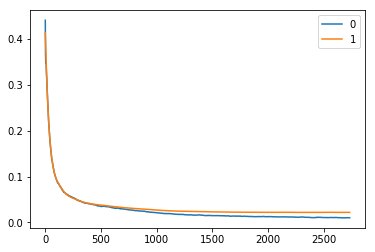

In [50]:
pd.DataFrame(losses[20:]).ewm(20).mean().plot()

In [24]:
voutputs = net.auto_encode_forward(xval)
# xval[0].cpu().data.numpy()[0]
# torch.save(net.state_dict(), 'auto_gan.net')

In [25]:
10

10

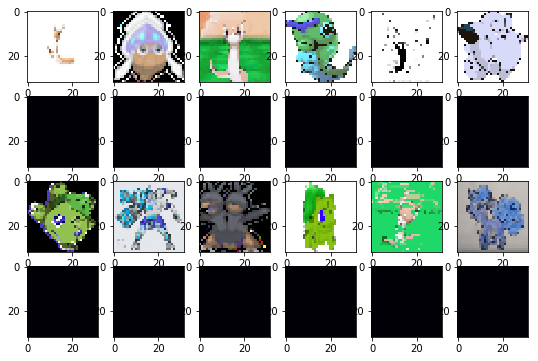

In [26]:
from matplotlib import pyplot as plt


fig, axes = plt.subplots(4, 6, figsize=(9,6))
fig.fig_size=(16,9)
for i in range(0, 4, 2):
    for j in range(6):
        axes[i, j].imshow(xval[i*6+j].cpu().data.numpy().transpose([1, 2, 0]))
        axes[i+1, j].imshow(voutputs[i*6+j].cpu().data.numpy().transpose([1, 2, 0]))


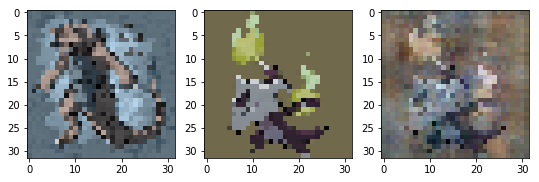

In [28]:
s1 = xval[[100]]
s2 = xval[[10]]
x1, id11, id21 = net.encode(s1)
x2, id12, id22 = net.encode(s2)
# print(id22)
ans = net.decode((x1+x2)/2, id12, id22)
fig, axes = plt.subplots(1, 3, figsize=(9,6))
axes[2].imshow(ans[0].cpu().data.numpy().transpose([1, 2, 0]))
axes[0].imshow(s1[0].cpu().data.numpy().transpose([1, 2, 0]))
axes[1].imshow(s2[0].cpu().data.numpy().transpose([1, 2, 0]))

In [63]:
net.load_state_dict(torch.load('auto_gan.net'))


In [66]:
import math
N = xtrain.size ()[0]
B = 20
NB = int(math.ceil(1.0*N/B))
T = 400
# T = 1
gamma = .001
rho = .9
# Training set size # Minibacth size
# Number of minibatches # Number of epochs # learning rate
# momentum
criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=gamma , momentum=rho)
dec_optimizer = torch.optim.Adam(net.parameters(), lr=gamma)
DECO = [net.fc3r, net.fc2r,net.fc1r, net.conv2r, net.conv1r]
DECO = reduce(lambda x, y: x+y, list(map(lambda x: [p for p in x.parameters()], DECO)), [])
# print(len(DECO))
generator_optimizer = torch.optim.Adam(DECO, lr=0.0001)

DESC = [net.descriminator_conv1, net.descriminator_conv2, net.descriminator] 
DESC = reduce(lambda x, y: x+y, list(map(lambda x: [p for p in x.parameters()], DESC)), [])
discriminator_optimizer = torch.optim.Adam(DESC, lr=0.001)

[1,   134] loss: 0.69375693 True

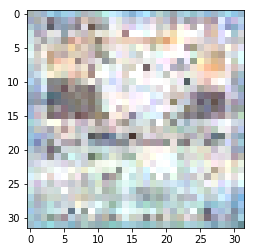

[2,   134] loss: 0.68439747 True

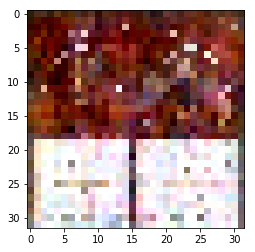

[3,   134] loss: 0.69641952 True

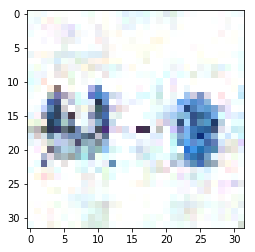

[4,   134] loss: 0.57297806 True

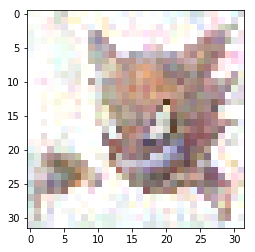

[5,   134] loss: 0.53000055 True

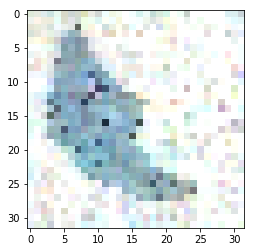

[6,   134] loss: 0.31384746 True

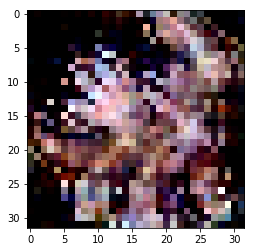

[7,   134] loss: 0.20446795 True

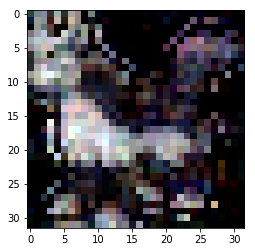

[8,   134] loss: 0.44993592 True

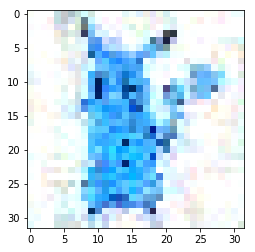

[9,   134] loss: 0.16733863 True

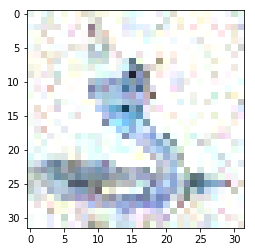

[10,   134] loss: 0.16423823 True

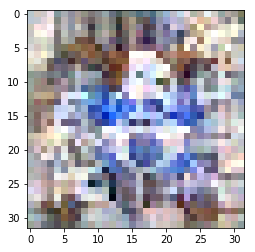

[11,   134] loss: 0.06978486 True

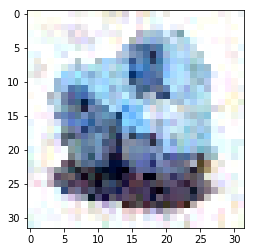

[12,   134] loss: 0.23011061 True

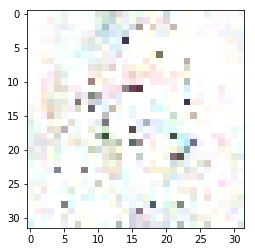

[13,   134] loss: 0.12057227 True

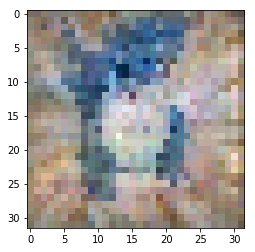

[14,   134] loss: 0.01360741 True

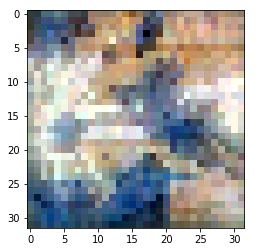

[15,   134] loss: 0.00309289 True

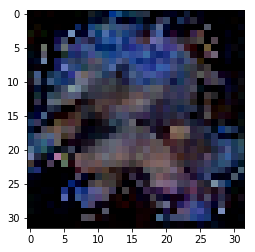

[16,   134] loss: 0.00055554 True

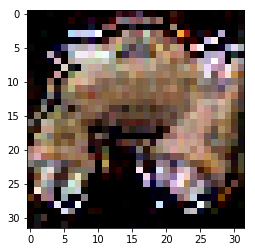

[17,   134] loss: 1.02927839 True

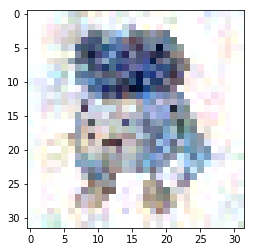

[18,   134] loss: 0.00486322 True

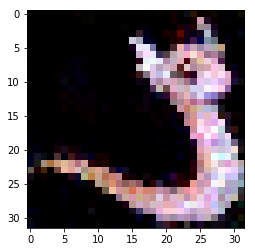

[19,   134] loss: 0.00472942 True

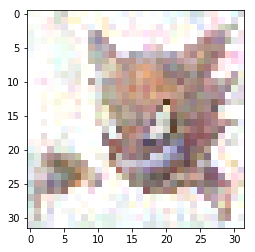

[20,   105] loss: 0.00348134 TrueChanr
[20,   134] loss: 88.12420998 False

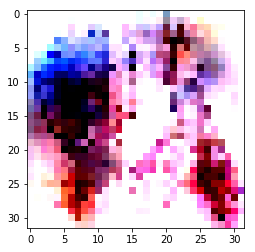

[21,   100] loss: 0.00053946 TrueeChanr
[21,   134] loss: 99.99952419 Falsee

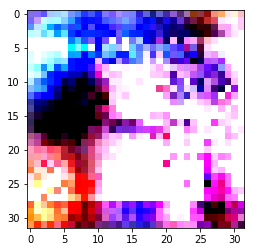

[22,   134] loss: 99.99977639 Falsee

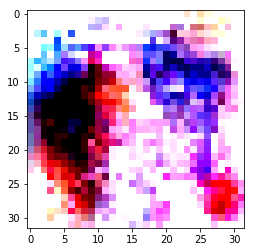

[23,     2] loss: 0.06304190 TrueChanr
[23,   134] loss: 99.99992713 Falsee

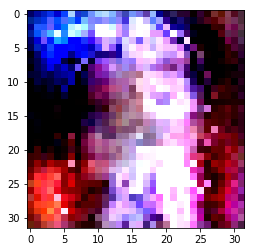

[24,   134] loss: 99.99999999 Falsee

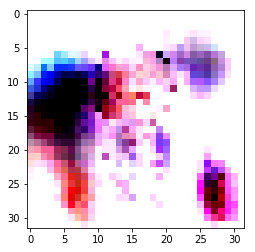

Chanr
[25,   134] loss: 99.97717125 Falsee

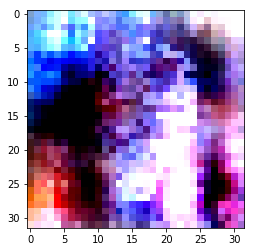

[26,   134] loss: 99.97302332 Falsee

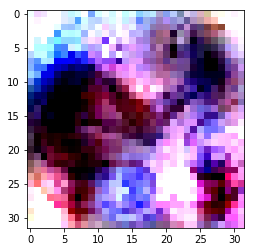

[27,     1] loss: 0.01546757 TrueChanr
[27,   134] loss: 84.80281177 Falsee

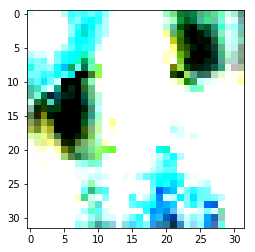

[28,   134] loss: 90.24286604 False

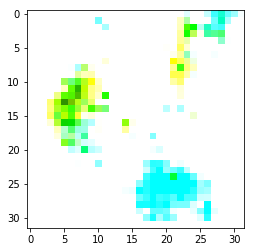

[29,   134] loss: 17.96016373 True

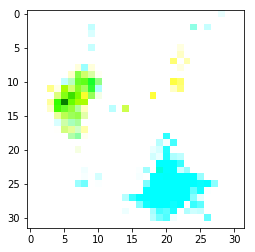

[30,   134] loss: 13.81551056 True

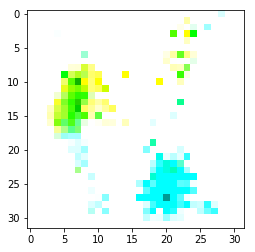

[31,   134] loss: 19.34171478 True

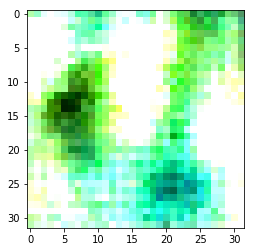

[32,   134] loss: 13.81551056 True

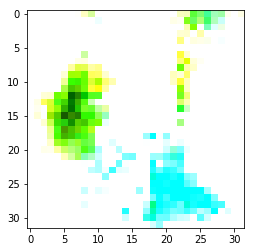

[33,   134] loss: 13.81551059 True

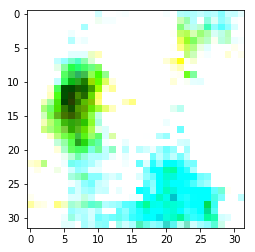

[34,   134] loss: 17.96016373 True

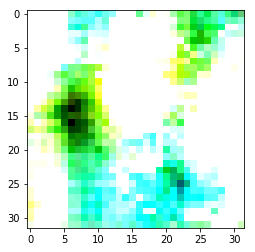

[35,   134] loss: 11.05240845 True

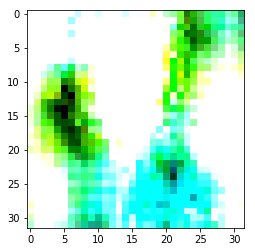

[36,   134] loss: 12.43395950 True

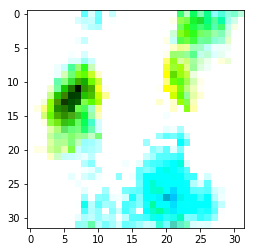

[37,   134] loss: 15.19706161 True

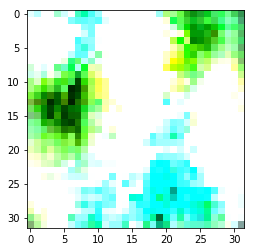

[38,   134] loss: 6.90775528 Truee

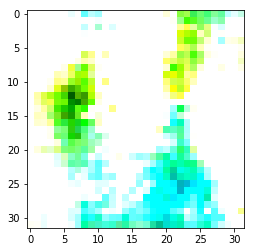

[39,   134] loss: 8.28930633 Truee

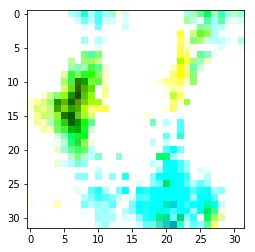

[40,   134] loss: 11.05240845 True

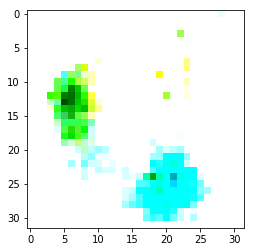

[41,   134] loss: 16.57861267 True

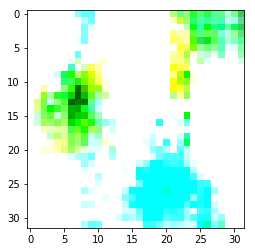

[42,   134] loss: 11.05240845 True

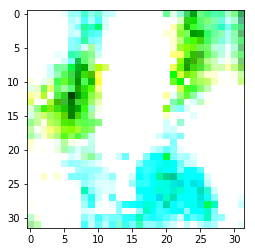

[43,   134] loss: 12.43395950 True

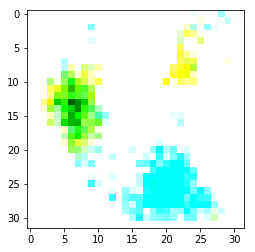

[44,   134] loss: 12.43395950 True

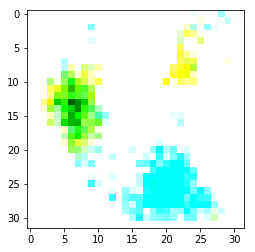

[45,   134] loss: 9.67085739 Truee

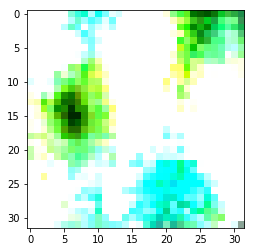

[46,   134] loss: 13.81551056 True

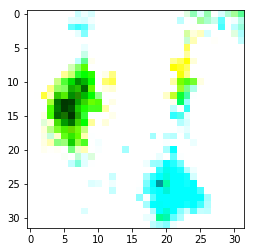

[47,   134] loss: 12.43395950 True

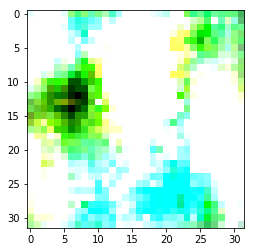

[48,   134] loss: 9.67085739 Truee

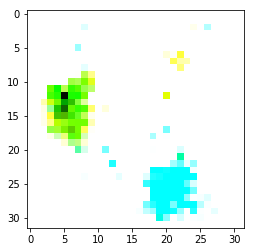

[49,   134] loss: 11.05240845 True

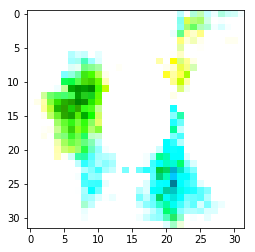

[50,   134] loss: 12.43395950 True

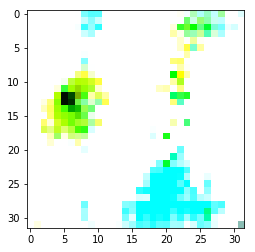

[51,   134] loss: 13.81551056 True

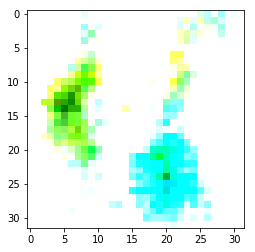

[52,   134] loss: 8.28930633 Truee

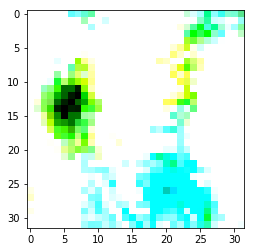

[53,   134] loss: 12.43395950 True

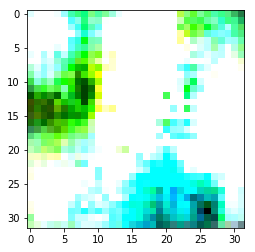

[54,   134] loss: 17.96016373 True

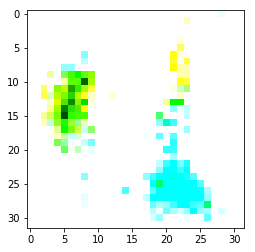

[55,   134] loss: 15.19706161 True

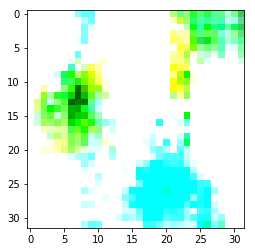

[56,   134] loss: 13.81551056 True

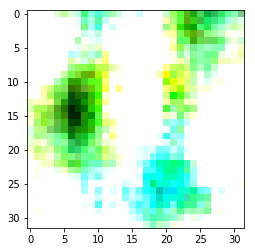

[57,   134] loss: 11.05240845 True

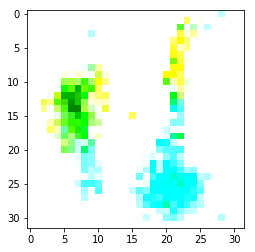

[58,   134] loss: 16.57861267 True

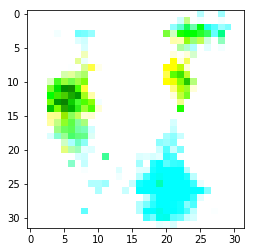

[59,   134] loss: 12.43395950 True

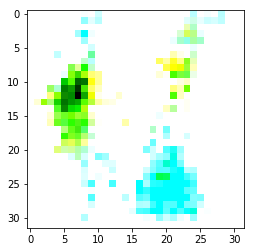

[60,   134] loss: 12.43395950 True

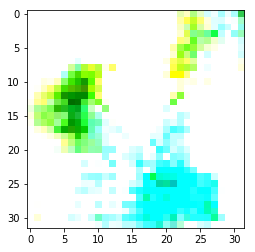

[61,   134] loss: 15.19706161 True

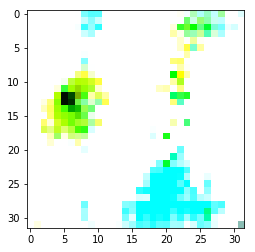

[62,   134] loss: 12.43395950 True

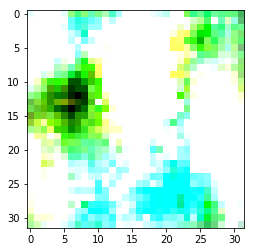

[63,   134] loss: 13.81551056 True

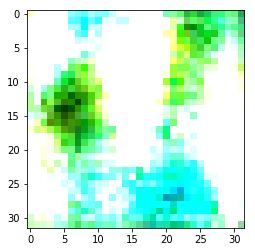

[64,   134] loss: 13.81551056 True

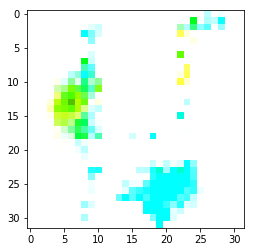

[65,   134] loss: 11.05240845 True

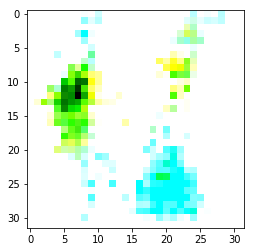

[66,   134] loss: 12.43395950 True

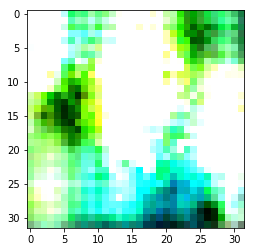

[67,   134] loss: 15.19706161 True

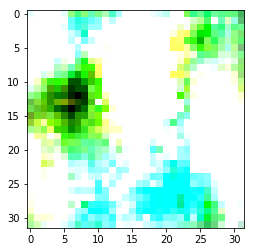

[68,   134] loss: 12.43395950 True

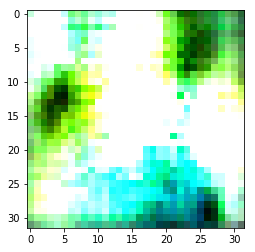

[69,   134] loss: 11.05240845 True

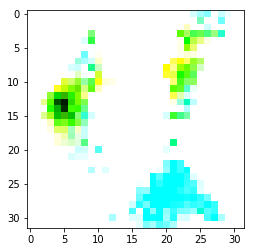

[70,   134] loss: 13.81551056 True

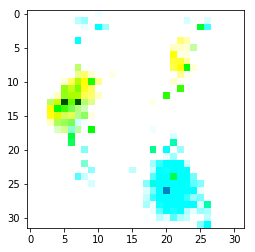

[71,   134] loss: 13.81551056 True

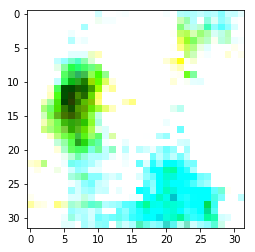

[72,   134] loss: 16.57861267 True

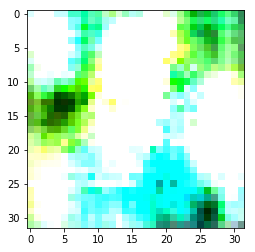

[73,   134] loss: 13.81551056 True

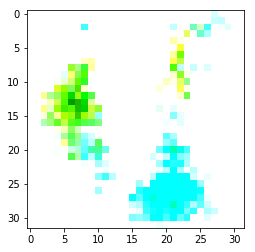

[74,   134] loss: 15.19706161 True

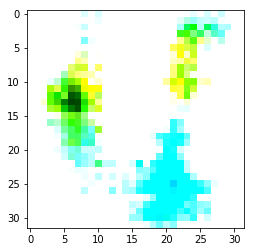

[75,   134] loss: 13.81551056 True

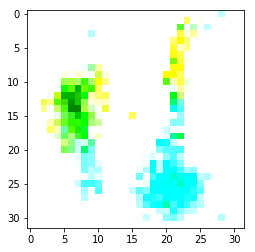

[76,   134] loss: 11.05240845 True

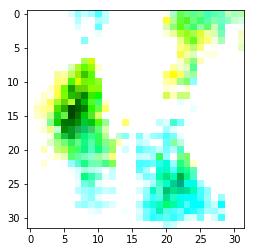

[77,    72] loss: 16.57861267 True

In [ ]:

des = True
losses = []
for epoch in range(T): 
    if epoch %2 == 0:
        des = True

    running_loss = 0.0 
    idxminibatches = np.random.permutation(NB)
    # shuffling 
    for k in range(NB): 
        i = idxminibatches[k] # index of minibatch
        # Extract i-th minibatch from xtrain and ltrain 
        
        idxsmp = np.arange(i, min(N, i+B)) # indices of samples for i-th minibatch 
        inputs = xtrain[idxsmp] 
        labels = xtrain_target[idxsmp]
        # Initialize the gradients to zero 
        optimizer.zero_grad()

        # Forward propagation 
        outputs = net.auto_encode_forward(inputs)
        
#         print(type(outputs.cpu().data), type(labels.cpu().data))

        # Error evaluation 
#         loss = criterion(outputs , labels)

        sel = ag.Variable((torch.ByteTensor(B).random_()<128).double().cuda(), requires_grad=False)
#         print(inputs.size(), sel.size())
#         print(sel)

        inp = inputs * sel.view(B, 1, 1, 1) + outputs * (1-sel.view(B, 1, 1, 1))
#         plt.imshow(inp[0].cpu().data.numpy().transpose([1, 2, 0]))
#         plt.show()
        
#         plt.imshow(inp[4].cpu().data.numpy().transpose([1, 2, 0]))
#         plt.show()
        
#         print(sel)
#         break
        out = net.discriminate(inp)
        loss = criterion(out[:,1] , sel)
        
        if not des:
            loss = 100-loss
        else:
            losses.append((loss[0].cpu().data.numpy()[0]))
        # Back propagation 
        loss.backward()
        

        # Parameter update 
        if des:
            discriminator_optimizer.step()
        else:
            generator_optimizer.step()
        
#         des = not des
#         voutputs = net.auto_encode_forward(xval[:100])
#         vloss = criterion(voutputs[:100] , xval[:100])

        # Print averaged loss per minibatch every 100 mini-batches
        if des and (loss[0].cpu().data.numpy()[0] < 0.1):
            print("Chanr")
            des = not des
#         print(k)
        if k % 1 == 0: 
            print('\r[%d, %5d] loss: %.8f %s' % (epoch + 1, k + 1, loss[0].cpu().data.numpy()[0], des), end="")
            running_loss = 0.0
#     break
    plt.imshow(outputs[0].cpu().data.numpy().transpose([1, 2, 0]))
    plt.show()

print ( ' Finished Training ' )
# pd.Series(losses).ewm(20).mean().plot()

Train Classifier

In [84]:
for param in net.parameters():
    param.requires_grad = False
for param in net.classifier.parameters():
    param.requires_grad = True

In [85]:
import math

N = xtrain.size ()[0]
B = 20
NB = int(math.ceil(1.0*N/B))
T = 150
# T = 1
gamma = .001
rho = .9
# Training set size # Minibacth size
# Number of minibatches # Number of epochs # learning rate
# momentum
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(net.classifier.parameters(), lr=gamma , momentum=rho)
optimizer = torch.optim.Adam(net.classifier.parameters(), lr=gamma)

In [98]:


losses = []
for epoch in range(T): 
    running_loss = 0.0 
    idxminibatches = np.random.permutation(NB)
    # shuffling 
    for k in range(NB): 
        i = idxminibatches[k] # index of minibatch
        # Extract i-th minibatch from xtrain and ltrain 
        
        idxsmp = np.arange(i, min(N, i+B)) # indices of samples for i-th minibatch 
        inputs = xtrain[idxsmp] 
        labels = ltrain[idxsmp]
        # Initialize the gradients to zero 
        optimizer.zero_grad ()

        # Forward propagation 
        outputs = net(inputs)
        
#         print(type(outputs.cpu().data), type(labels.cpu().data))

        # Error evaluation 
#         loss = criterion(outputs , labels)
        
        loss = criterion(outputs , torch.max(labels, 1)[1])
        
        # Back propagation 
        loss.backward()

        # Parameter update 
        optimizer.step()
        
        voutputs = net(xval[:100])
        vloss = criterion(voutputs[:100] , torch.max(lval[:100], 1)[1])

        # Print averaged loss per minibatch every 100 mini-batches
        running_loss+= loss[0] 
#         print(k)
        losses.append((running_loss.cpu().data.numpy()[0], vloss[0].cpu().data.numpy()[0]))
        if k % 1 == 0: 
            print('\r[%d, %5d] loss: %.8f ' % (epoch + 1, k + 1, running_loss), end="")
            running_loss = 0.0 

print ( ' Finished Training ' )
# pd.Series(losses).ewm(20).mean().plot()

[41,    99] loss: 2.53078483 

KeyboardInterrupt: 

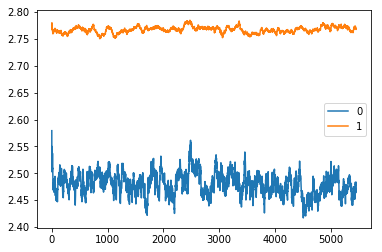

In [100]:
pd.DataFrame(losses).ewm(20).mean().plot()

In [101]:
# np.random.permutation(NB)
ytrained = net(xval)
if torch.cuda.is_available():
    ytrained = ytrained.cpu()
    
print (100 * np.mean(lval.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argmax(axis =0)))

15.076071922544951


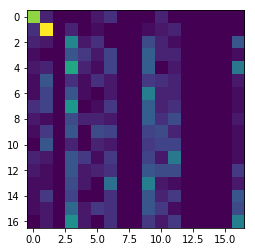

In [102]:
from sklearn.metrics import confusion_matrix

pyplot.imshow(confusion_matrix(lval.cpu().data.numpy().T.argmax(axis=0), ytrained.data.numpy().T.argmax(axis =0)),)

In [103]:
ytrained = net(xtrain)
if torch.cuda.is_available():
    ytrained = ytrained.cpu()
    
print (100 * np.mean(ltrain.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argmax(axis =0)))

18.07994023160254


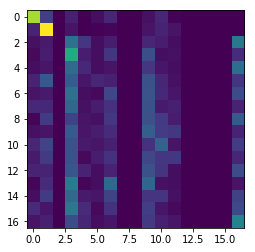

In [97]:
from sklearn.metrics import confusion_matrix

pyplot.imshow(confusion_matrix(ltrain.cpu().data.numpy().T.argmax(axis=0), ytrained.data.numpy().T.argmax(axis =0)),)